In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
engine.execute('SELECT * FROM Station LIMIT 10').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [11]:
engine.execute('SELECT * FROM Measurement LIMIT 10').fetchall()


[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

# Exploratory Climate Analysis

In [31]:
## Design a query to retrieve the last 12 months of precipitation data and plot the results

# We don't know what is the last date.We have to find it out.
last_day =session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print('The last day is:')
print(last_day)

#retrive the last 12 months
last_12_months= dt.date(2017,8,23) - dt.timedelta(days=365)
print('The day a year ago is:')
print(last_12_months)

#Now we can substract the amount of precipitations from the last 12 months
precip_12_months=session.query(Measurement.date, Measurement.prcp).\
filter(Measurement.date > last_12_months).order_by(Measurement.date).all()


The last day is:
('2017-08-23',)
The day a year ago is:
2016-08-23


In [13]:
#Save the query results as a Pandas DataFrame and set the index to the date column
precip_12_months_df=pd.DataFrame(precip_12_months)
#precip_12_months_df = precip_12_months_df.set_index('date')
precip_12_months_df.head()

,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22


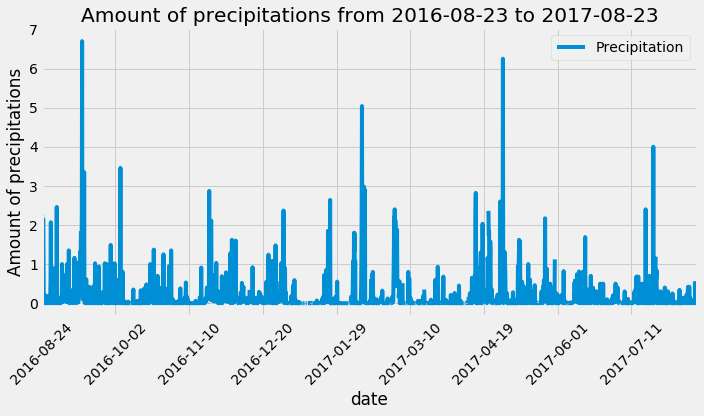

In [14]:
#Use Pandas Plotting with Matplotlib to plot the data
precip_12_months_df.plot('date','prcp',figsize=(10,6))
plt.xlabel('date')
plt.ylabel('Amount of precipitations')
plt.title('Amount of precipitations from 2016-08-23 to 2017-08-23')
plt.legend(['Precipitation'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../Precipitations.png")
plt.show()

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_12_months_df=pd.DataFrame(precip_12_months)
precip_12_months_df = precip_12_months_df.set_index('date')
precip_12_months_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

In [32]:
# Design a query to show how many stations are available in this dataset?
nb_station =session.query(Measurement).group_by(Measurement.station).count()
print("There are {} stations.".format(nb_station))

9
There are 9 stations.


In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
active_station =session.query(Measurement.station, func.count(Measurement.station)).\
                group_by(Measurement.station).\
                order_by(func.count(Measurement.station).desc()).all()

the_most = active_station[0][0]    
for station, count in active_station:
    print(station,"has",count,'rows')

# List the stations and the counts in descending order.


USC00519281 has 2772 rows
USC00519397 has 2724 rows
USC00513117 has 2709 rows
USC00519523 has 2669 rows
USC00516128 has 2612 rows
USC00514830 has 2202 rows
USC00511918 has 1979 rows
USC00517948 has 1372 rows
USC00518838 has 511 rows


In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
low_high_avg_temps = session.query(func.min(Measurement.tobs), 
                                   func.max(Measurement.tobs),
                                   func.avg(Measurement.tobs)).\
                                   filter(Measurement.station == the_most).all()
print(low_high_avg_temps)


[(54.0, 85.0, 71.66378066378067)]


In [51]:
# Choose the station with the highest number of temperature observations.
highest_nb_obsv = session.query(Measurement.station,func.count(Measurement.tobs)).\
                  group_by(Measurement.station).\
                  order_by(func.count(Measurement.station).desc()).first()

print("Station {}".format(highest_nb_obsv),"has the most observations")



Station ('USC00519281', 2772) has the most observations


In [20]:
# Query the last 12 months of temperature observation data for this station 
temp_12_months=session.query(Measurement.station,Measurement.date,Measurement.tobs).\
               filter(Measurement.date > last_12_months).\
               filter(Measurement.station == highest_nb_obsv).\
               order_by(Measurement.date).all()

temp_12_months=pd.DataFrame(temp_12_months, columns=['station','date','Temperature'])
temp_12_months.tail()

,station,date,Temperature
346,USC00519281,2017-08-14,77.0
347,USC00519281,2017-08-15,77.0
348,USC00519281,2017-08-16,76.0
349,USC00519281,2017-08-17,76.0
350,USC00519281,2017-08-18,79.0


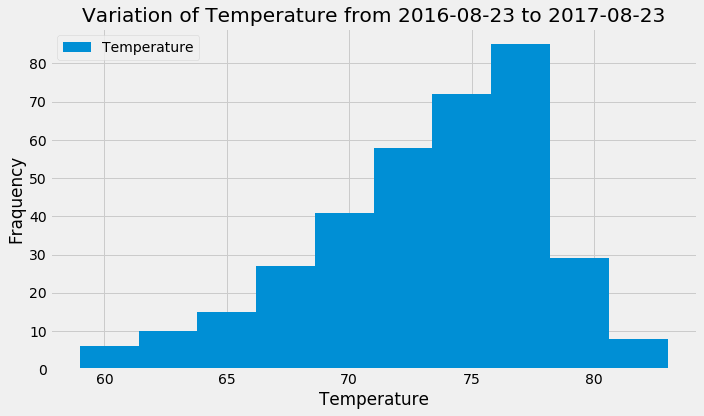

In [21]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
temp_12_months.hist('Temperature',figsize=(10,6))
plt.xlabel('Temperature')
plt.ylabel('Fraquency')
plt.title('Variation of Temperature from 2016-08-23 to 2017-08-23')
plt.legend(['Temperature'])
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("../Temperature.png")
plt.show()

## Temperature Analysis

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))


[(62.0, 69.57142857142857, 74.0)]


In [52]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
@my_trip=calc_temps('2017-03-15', '2017-03-30')
my_trip=pd.DataFrame(my_trip, columns=['TMIN','TAVG','TMAX'])
my_trip.head()
my_trip=session.query(Measurement.date, Measurement.tobs).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

SyntaxError: invalid syntax (<ipython-input-52-19e613b96305>, line 3)

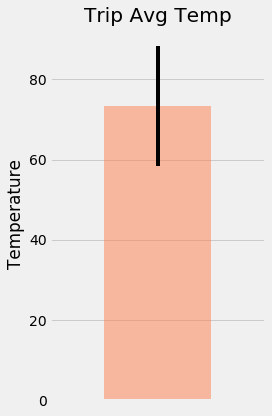

In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
yerr=(my_trip['TMAX']-my_trip['TMIN'])
my_trip.plot.bar(y='TAVG', yerr=yerr, title='Trip Avg Temp', color='coral', alpha=0.5, figsize=(4,6))
plt.xticks(np.arange(1, 1.0))
plt.ylabel("Temperature")
plt.tight_layout()
plt.gca().legend_.remove()
plt.savefig("../TripAvgTemp.png")
plt.show()

In [25]:
# Calculate the total amount of rainfall per weather station for your trip dates using 
#the previous year's matching dates.
# Sort this in descending order by 
#precipitation amount and list the station, name, latitude, longitude, and elevation

def calc_prcp(start_date, end_date):
    
    return session.query(
                         Measurement.station,\
                         Station.name,\
                         Measurement.prcp,\
                         Station.latitude,\
                         Station.longitude,\
                         Station.elevation).\
                         filter(Measurement.date >= start_date).\
                         filter(Measurement.date <= end_date).\
                         filter(Measurement.station == Station.station).\
                         group_by(Measurement.station).\
                         order_by(Measurement.prcp.desc()).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [26]:
my_trip_prcp=calc_prcp('2017-03-15', '2017-03-30')
my_trip_prcp=pd.DataFrame(my_trip_prcp, columns=['Station','Name','Precipitation','Lat','Long','Elevation'])
my_trip_prcp.head()

,Station,Name,Precipitation,Lat,Long,Elevation
0,USC00519281,"WAIHEE 837.5, HI US",0.06,21.45167,-157.84889,32.9
1,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.00,21.33556,-157.71139,19.5
2,USC00519397,"WAIKIKI 717.2, HI US",0.00,21.27160,-157.81680,3.0
3,USC00517948,"PEARL CITY, HI US",0.00,21.39340,-157.97510,11.9
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",0.00,21.33310,-157.80250,152.4


# Optional Challenge Assignment

#### -----> Credit to a friend for helping understand how to solve the Optional Question <-----

In [27]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("03-30")

[(62.0, 72.17543859649123, 79.0)]

In [28]:

# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-03-15'
end_date ='2017-03-30'
# Use the start and end date to create a range of dates

dates = session.query(Measurement.date).\
        filter(Measurement.date >= start_date).\
        filter(Measurement.date <= end_date).\
        group_by(Measurement.date).all()

# List comprehension to get the elements in the tuple from the dates query 
trip_dates = [x[0] for x in dates]

# Stip off the year and save a list of %m-%d strings with another list comprehension 
trip_dates_stripped= [x[5:] for x in trip_dates]

# Find the start month/day and the end month/day 
start_month_day = trip_dates_stripped[0]
end_month_day = trip_dates_stripped[-1]

# Loop through the list of %m-%d strings and calculate the normals for each date    
daily_normals = [session.query(func.min(Measurement.tobs),
                func.avg(Measurement.tobs),
                func.max(Measurement.tobs)).\
                filter(func.strftime("%m-%d", Measurement.date) >= start_month_day).\
                filter(func.strftime("%m-%d", Measurement.date) <= end_month_day).\
                group_by(func.strftime("%m-%d", Measurement.date)).all()]

daily_normals = daily_normals[0]

daily_normals

[(58.0, 68.54716981132076, 76.0),
 (60.0, 69.70370370370371, 78.0),
 (57.0, 68.54, 75.0),
 (57.0, 67.7843137254902, 76.0),
 (60.0, 69.1, 75.0),
 (62.0, 70.11764705882354, 80.0),
 (60.0, 71.07692307692308, 77.0),
 (65.0, 71.75471698113208, 77.0),
 (63.0, 70.79629629629629, 78.0),
 (62.0, 71.5, 77.0),
 (63.0, 71.5, 78.0),
 (64.0, 71.38, 80.0),
 (63.0, 71.53846153846153, 80.0),
 (59.0, 71.51785714285714, 82.0),
 (58.0, 71.35714285714286, 77.0),
 (62.0, 72.17543859649123, 79.0)]

In [29]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
# Create a dataframe from the previous query 
daily_normals_df= pd.DataFrame(daily_normals, columns=['TMIN', 'TAVG', 'TMAX'])

# Add trip_dates to Pandas DataFrame
daily_normals_df['date']= trip_dates

# Change datatype from element to datetime object on Pandas, makes x axis title to add 
daily_normals_df['date'] = pd.to_datetime(daily_normals_df['date'], format='%Y-%m-%d')

# Set index to date
daily_normals_df.set_index('date',inplace=True)

daily_normals_df.head()

,TMIN,TAVG,TMAX
date,,,
2017-03-15,58.0,68.547170,76.0
2017-03-16,60.0,69.703704,78.0
2017-03-17,57.0,68.540000,75.0
2017-03-18,57.0,67.784314,76.0
2017-03-19,60.0,69.100000,75.0


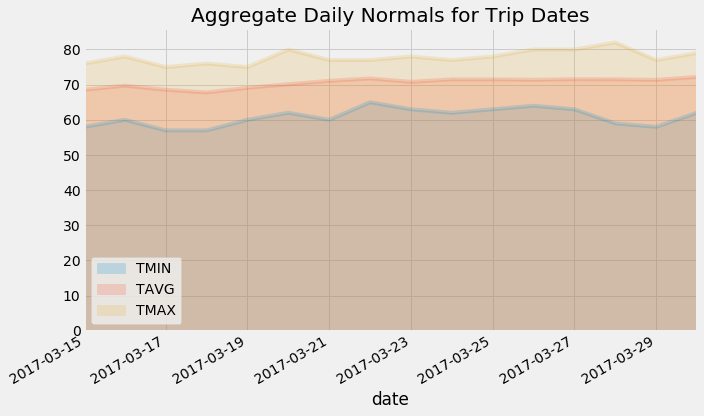

In [30]:
# Plot the daily normals as an area plot with `stacked=False`
daily_normals_df.plot(kind='area', alpha=.2, stacked=False, x_compat=True, figsize=(10,6), title="Aggregate Daily Normals for Trip Dates")
plt.tight_layout()
plt.savefig("../DailyNormals.png")
plt.show()